<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec7-NLP_ANN/2-Text_Classification_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn
import torchtext.legacy.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
!git clone https://github.com/comchem/Pytorch_DeepLearning_Tutorials.git

fatal: destination path 'Pytorch_DeepLearning_Tutorials' already exists and is not an empty directory.


In [6]:
path = './Pytorch_DeepLearning_Tutorials/data/spam.csv'
df = pd.read_csv(path, encoding='ISO-8859-1')

In [7]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [9]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# rename columns to something better
df.columns = ['labels', 'data']

In [11]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})

In [13]:
df2 = df[['data', 'b_labels']]

In [14]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [15]:
df2.to_csv('spam2.csv', index=False)

In [16]:
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = True,
    # tokenize = 'spacy',
    pad_first = True
)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True)

# Note: if you don't specify use_vocab = False, then Pytorch will complain later when you try 
# to iterate over the dataset that the attribute 'vocab' doesn't exist.

# Note 2: if you don't specify is_target = True, then Pytorch will assume it's part of the input,
# so when you iterate over the dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path = 'spam2.csv',
    format = 'csv',
    skip_header = True,
    fields = [('data', TEXT), ('label', LABEL)]
)

In [17]:

train_dataset, test_dataset = dataset.split()  # default is 0.7 

In [18]:
TEXT.build_vocab(train_dataset)

In [19]:
vocab = TEXT.vocab
type(vocab)

torchtext.vocab.Vocab

In [20]:
#vocab.stoi

In [21]:
#vocab.itos

In [22]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), sort_key = lambda x: len(x.data),
    batch_sizes = (2,2), device = device
)

In [24]:
for inputs, targets in train_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shape:", targets.shape)
  break

inputs: tensor([[1162,  109,    4,   18,   14,   37,   48,  652],
        [   1,    1,    1,  984,   42, 3020,    4, 1412]], device='cuda:0') shape: torch.Size([2, 8])
targets: tensor([0, 0], device='cuda:0') shape: torch.Size([2])


In [25]:
for inputs, targets in test_iter:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shape:", targets.shape)
  break

inputs: tensor([[267],
        [267]], device='cuda:0') shape: torch.Size([2, 1])
targets: tensor([0, 0], device='cuda:0') shape: torch.Size([2])


In [26]:
len(vocab)

10840

In [27]:
### Define the model
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim    # Pretrained vectors
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
          input_size = self.D,
          hidden_size = self.M,
          num_layers = self.L,
          batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # embedding layer --> N x T --> N x T x D
        # turns word indexes into word vectors
        out = self.embed(X)

        # get RNN unit output --> N x T x D --> N x T x M
        out, _ = self.rnn(out, (h0, c0))

        # max pool --> N x T x M --> N x M
        out, _ = torch.max(out, 1)
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out)
        return out

In [28]:
# Instantiate the model
model = RNN(n_vocab = len(vocab), embed_dim = 20, n_hidden=15, n_rnnlayers = 1, n_outputs = 1)
model.to(device)

RNN(
  (embed): Embedding(10840, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [36]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [37]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      # move data to GPU  
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      
    # Get train loss and test loss
    train_loss = np.mean(train_loss)   # a little misleading

    test_loss = []
    for inputs, targets in test_iter:
      #inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1,1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0      
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [38]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 15
)

Epoch 1/15, Train Loss: 0.0162, Test Loss: 0.2467, Duration: 0:00:09.608380
Epoch 2/15, Train Loss: 0.0091, Test Loss: 0.2543, Duration: 0:00:09.583323
Epoch 3/15, Train Loss: 0.0056, Test Loss: 0.2369, Duration: 0:00:09.551700
Epoch 4/15, Train Loss: 0.0024, Test Loss: 0.2412, Duration: 0:00:09.524711
Epoch 5/15, Train Loss: 0.0030, Test Loss: 0.2375, Duration: 0:00:09.525041
Epoch 6/15, Train Loss: 0.0027, Test Loss: 0.2367, Duration: 0:00:09.517020
Epoch 7/15, Train Loss: 0.0014, Test Loss: 0.2499, Duration: 0:00:09.530793
Epoch 8/15, Train Loss: 0.0031, Test Loss: 0.2519, Duration: 0:00:09.546023
Epoch 9/15, Train Loss: 0.0023, Test Loss: 0.2353, Duration: 0:00:09.510326
Epoch 10/15, Train Loss: 0.0017, Test Loss: 0.2452, Duration: 0:00:09.550639
Epoch 11/15, Train Loss: 0.0027, Test Loss: 0.2468, Duration: 0:00:09.573667
Epoch 12/15, Train Loss: 0.0007, Test Loss: 0.2480, Duration: 0:00:09.507350
Epoch 13/15, Train Loss: 0.0008, Test Loss: 0.2497, Duration: 0:00:09.513334
Epoch 14

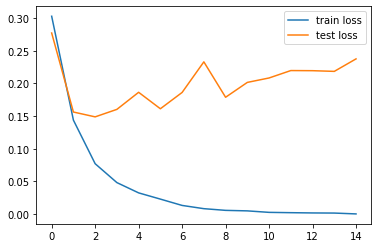

In [32]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [39]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
    targets = targets.view(-1, 1).float()
    
    # Forward pass
    outputs = model(inputs)
    #print(outputs.shape)
    
    # Get prediction
    predictions = (outputs > 0)
    # print(_, predictions)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    predictions = (outputs > 0)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 1.0000, Test acc: 0.9713
